In [2]:
import h5py
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
filename = "/Users/forero/Illustris_data/TNG300-1/groups_099/rL205n2500TNG_Subhalo_3DStellarMasses_099.hdf5"
f = h5py.File(filename, 'r')
keys = list(f.keys())
print(keys)
print(list(f['Subhalo']))
rescaled_stellar_mass = f['Subhalo/StellarMasses_in_Rad'][...]
done_field = f['Subhalo/Done'][...]
f.close()

['Header', 'Subhalo']
['Done', 'StellarMasses_in_HalfRad', 'StellarMasses_in_Rad', 'StellarMasses_in_r100ckpc', 'StellarMasses_in_r100pkpc', 'StellarMasses_in_r10ckpc', 'StellarMasses_in_r10pkpc', 'StellarMasses_in_r30ckpc', 'StellarMasses_in_r30pkpc', 'StellarMasses_in_r50ckpc', 'StellarMasses_in_r50pkpc']


In [4]:
print(np.count_nonzero(done_field==1))
print(len(done_field))

14485709
14485709


In [5]:
basePath = "/Users/forero/Illustris_data/TNG300-1/"
subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 'SubhaloVmax','SubhaloMassType',
                  'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr', 'SubhaloStellarPhotometrics']
all_subhalos = gc.loadSubhalos(basePath,99, fields=subhalo_fields)
header = gc.loadHeader(basePath,99)
all_subhalos['stellar_mass'] = rescaled_stellar_mass

In [6]:
halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_M_Mean200',
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub', 'GroupMassType']
halos = gc.loadHalos(basePath,99, fields=halo_fields) # the selection is based on the FOF groups

In [8]:
all_subhalos['Halo_mass_M_Mean200'] = halos['Group_M_Mean200'][all_subhalos['SubhaloGrNr']]

ii = all_subhalos['stellar_mass'] > 1.0E10
print(np.count_nonzero(ii))

150937


In [20]:
subhalos = all_subhalos.copy()
del subhalos['count']
for k in subhalos.keys():
    subhalos[k] = all_subhalos[k][ii]

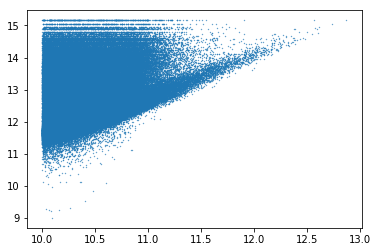

In [24]:
plt.scatter(np.log10(subhalos['stellar_mass']), np.log10(subhalos['Halo_mass_M_Mean200']*1E10), s =0.1)

array({'SubhaloMass': array([1.2833460e+05, 3.6333289e+04, 8.9640430e+02, ..., 1.0755254e-01,
       1.0356911e-01, 1.1153597e-01], dtype=float32), 'SubhaloSFRinRad': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'SubhaloPos': array([[ 43718.812 ,  48813.64  , 147594.95  ],
       [ 45442.273 ,  51850.2   , 146416.5   ],
       [ 44490.76  ,  49091.715 , 147870.58  ],
       ...,
       [197120.53  , 130808.47  , 128705.41  ],
       [203046.77  ,   5473.9346,  41674.94  ],
       [197568.16  , 171988.39  ,  58274.793 ]], dtype=float32), 'SubhaloVmax': array([1744.1304  , 1314.5017  ,  516.6094  , ...,   19.764599,
         17.153547,   18.599667], dtype=float32), 'SubhaloMassType': array([[1.9187549e+04, 1.0860912e+05, 0.0000000e+00, 0.0000000e+00,
        5.3094843e+02, 6.9895449e+00],
       [5.0698311e+03, 3.1006744e+04, 0.0000000e+00, 0.0000000e+00,
        2.5366284e+02, 3.0504403e+00],
       [0.0000000e+00, 8.3860309e+02, 0.0000000e+00, 0.0000000e+00,
        5.7365696e+